Reference - https://github.com/Daniel-EST/deep-steganography

In [24]:
import tensorflow as tf

In [25]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [26]:
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-4

In [27]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, n_layers, filters=50, kernel_size=(3, 3), activation=tf.nn.relu, **kwargs):
        super().__init__(**kwargs)
        self.convs = []
        for conv in range(n_layers):
            self.convs.append(
                tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
            )

    def call(self, input_tensor, training=False):
        x = self.convs[0](input_tensor, training=training)
        for i in range(1, len(self.convs)):
            x = self.convs[i](x, training=training)

        return x

In [29]:
class PrepLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

    def call(self, input_tensor, training=False):
        prep_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor.shape)(input_tensor)
        conv_4_3x3 = self.conv_layer_4_3x3(prep_input, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(prep_input, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(prep_input, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        return self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

In [30]:
class HideLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_3 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):
        prep_input = input_tensor[0]
        hide_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor[1].shape)(input_tensor[1])
        concat_1 = self.concat_1([prep_input, hide_input])

        conv_4_3x3 = self.conv_layer_4_3x3(concat_1, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(concat_1, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(concat_1, training=training)

        concat_2 = self.concat_2([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_2)
        conv_1_4x4 =  self.conv_1_4x4(concat_2)
        conv_1_5x5 =  self.conv_1_5x5(concat_2)

        concat_3 = self.concat_3([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_3)

In [31]:
class RevealLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):

        conv_4_3x3 = self.conv_layer_4_3x3(input_tensor, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(input_tensor, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(input_tensor, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        concat_2 = self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_2)

In [32]:
class MyModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.hide_layer = HideLayer()
        self.reveal_layer = RevealLayer()

    def call(self, input_tensor, training=False):
        secret = input_tensor[0]
        cover = input_tensor[1]
        prep_output = self.prep_layer(secret)
        hide_output = self.hide_layer([prep_output, cover])
        reveal_output = self.reveal_layer(hide_output)

        return  reveal_output, hide_output

    def model(self, inputs):
        return tf.keras.Model(inputs=inputs, outputs=self.call(inputs))

In [33]:
class StenographyLoss(tf.keras.losses.Loss):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, y_true, y_pred):
        beta = tf.constant(self.beta, name='beta')

        secret_true = y_true[0]
        secret_pred = y_pred[0]

        cover_true = y_true[1]
        cover_pred = y_pred[1]

        secret_mse = tf.losses.MSE(secret_true, secret_pred)
        cover_mse = tf.losses.MSE(cover_true, cover_pred)

        return tf.reduce_mean(cover_mse + beta * secret_mse)

In [34]:
secret_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_input')
cover_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_input')

model = MyModel().model(inputs=[secret_input, cover_input])

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 secret_input (InputLayer)   [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 prep_layer_2 (PrepLayer)    (None, 64, 64, 150)          758250    ['secret_input[0][0]']        
                                                                                                  
 cover_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 hide_layer_1 (HideLayer)    (None, 64, 64, 3)            1133703   ['prep_layer_2[0][0]',        
                                                                     'cover_input[0][0]']   

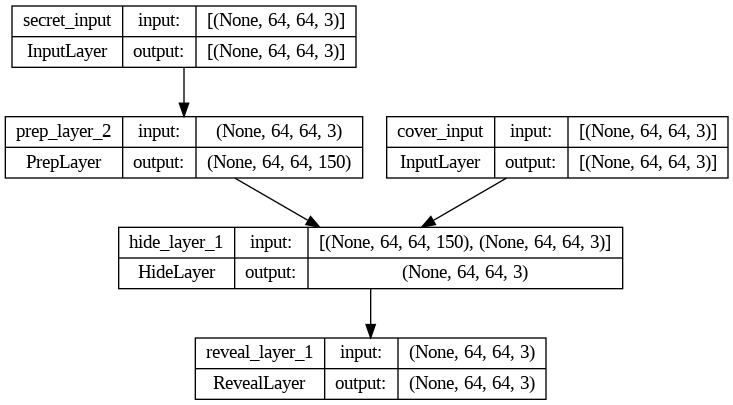

In [36]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [37]:
optmizer = tf.optimizers.Adam(LEARNING_RATE)
stenography_loss = StenographyLoss(beta=1.0)

model.compile(
    optimizer=optmizer,
    loss=stenography_loss,
)

In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [16]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [39]:
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
dataset = load_dataset("Maysee/tiny-imagenet")

In [40]:
from sklearn.model_selection import train_test_split

train_data, _ = train_test_split(dataset['train']['image'], train_size=.15) # Getting a subset of the Tiny ImageNet dataset.

X_train, X_test = train_test_split(train_data, test_size=.1)
X_train_secret, X_train_cover = train_test_split(X_train, test_size=.5)
X_test_secret, X_test_cover = train_test_split(X_test, test_size=.5)
X_val_secret, X_val_cover = train_test_split(dataset['valid']['image'], test_size=.5)

del X_train
del X_test
del train_data

In [41]:
import matplotlib.pyplot as plt

def show_image(arr):
    plt.imshow(np.array(arr, np.int32))
    return plt

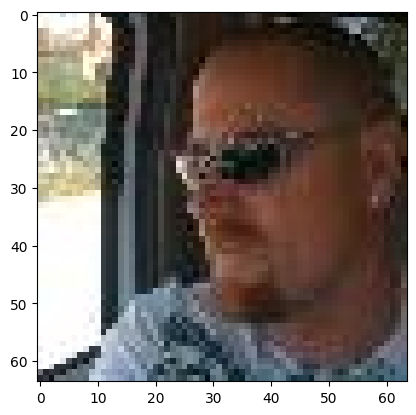

In [42]:
show_image(X_train_cover[0]).show()

In [43]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, secret, cover, batch_size, shuffle=True):
        self.secret = secret
        self.cover = cover
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.datalen = len(secret)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index: int):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        secret_batch = np.array(self.secret)[batch_indexes]
        cover_batch = np.array(self.cover)[batch_indexes]

        return [secret_batch, cover_batch], [secret_batch, cover_batch]

    def __len__(self):
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [44]:
for i in range(len(X_train_secret)):
    X_train_secret[i] = tf.keras.utils.img_to_array(X_train_secret[i].convert('RGB'))
    X_train_cover[i] = tf.keras.utils.img_to_array(X_train_cover[i].convert('RGB'))

for i in range(len(X_test_secret)):
    X_test_secret[i] = tf.keras.utils.img_to_array(X_test_secret[i].convert('RGB'))
    X_test_cover[i] = tf.keras.utils.img_to_array(X_test_cover[i].convert('RGB'))

for i in range(len(X_val_secret)):
    X_val_secret[i] = tf.keras.utils.img_to_array(X_val_secret[i].convert('RGB'))
    X_val_cover[i] = tf.keras.utils.img_to_array(X_val_cover[i].convert('RGB'))

In [45]:
train_gen = DataGenerator(X_train_secret, X_train_cover, BATCH_SIZE)
test_gen = DataGenerator(X_test_secret, X_test_cover, BATCH_SIZE, shuffle=False)
val_gen = DataGenerator(X_val_secret, X_val_cover, BATCH_SIZE, shuffle=False)

In [46]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/5
210/210 [==============================] - 149s 647ms/step - loss: 24518.0684 - reveal_layer_1_loss: 11342.5586 - hide_layer_1_loss: 13175.5068 - val_loss: 18254.6641 - val_reveal_layer_1_loss: 11410.4170 - val_hide_layer_1_loss: 6844.2534
Epoch 2/5
210/210 [==============================] - 135s 642ms/step - loss: 9453.8770 - reveal_layer_1_loss: 4853.6016 - hide_layer_1_loss: 4600.2720 - val_loss: 6965.7739 - val_reveal_layer_1_loss: 3502.3213 - val_hide_layer_1_loss: 3463.4519
Epoch 3/5
210/210 [==============================] - 136s 645ms/step - loss: 5879.0127 - reveal_layer_1_loss: 3100.4126 - hide_layer_1_loss: 2778.5969 - val_loss: 5623.2666 - val_reveal_layer_1_loss: 2695.7319 - val_hide_layer_1_loss: 2927.5361
Epoch 4/5
210/210 [==============================] - 136s 645ms/step - loss: 5515.6987 - reveal_layer_1_loss: 2915.7200 - hide_layer_1_loss: 2599.9768 - val_loss: 5311.5303 - val_reveal_layer_1_loss: 2589.1389 - val_hide_layer_1_loss: 2722.3901
Epoch 5/5
210/2

In [47]:
pred = model.predict(test_gen)

23/23 [==============================] - 4s 147ms/step


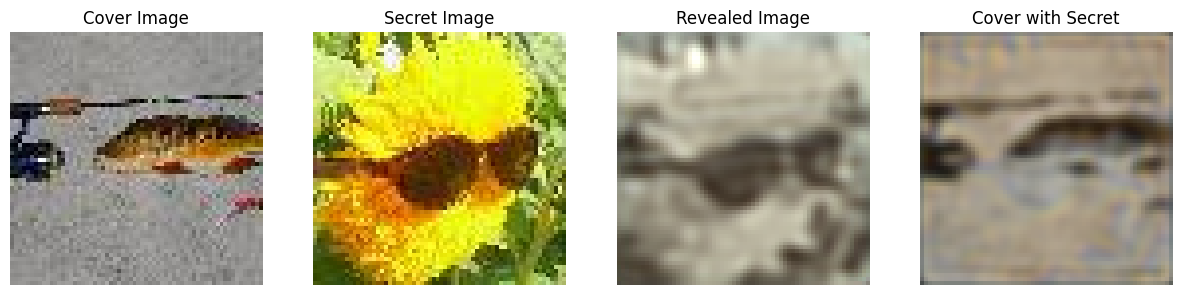

In [48]:
#to display all the results in a grid
import matplotlib.pyplot as plt

def display_images(cover, secret, revealed, cover_with_secret):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot cover image
    axes[0].imshow(cover.astype(int))
    axes[0].set_title('Cover Image')
    axes[0].axis('off')

    # Plot secret image
    axes[1].imshow(secret.astype(int))
    axes[1].set_title('Secret Image')
    axes[1].axis('off')


    # Plot cover image with secret
    axes[3].imshow(cover_with_secret.astype(int))
    axes[3].set_title('Cover with Secret')
    axes[3].axis('off')



    # Plot revealed image
    axes[2].imshow(revealed.astype(int))
    axes[2].set_title('Revealed Image')
    axes[2].axis('off')

    plt.show()

# Display sample images
sample_index = 0
display_images(X_test_cover[sample_index], X_test_secret[sample_index], pred[0][sample_index], pred[1][sample_index])


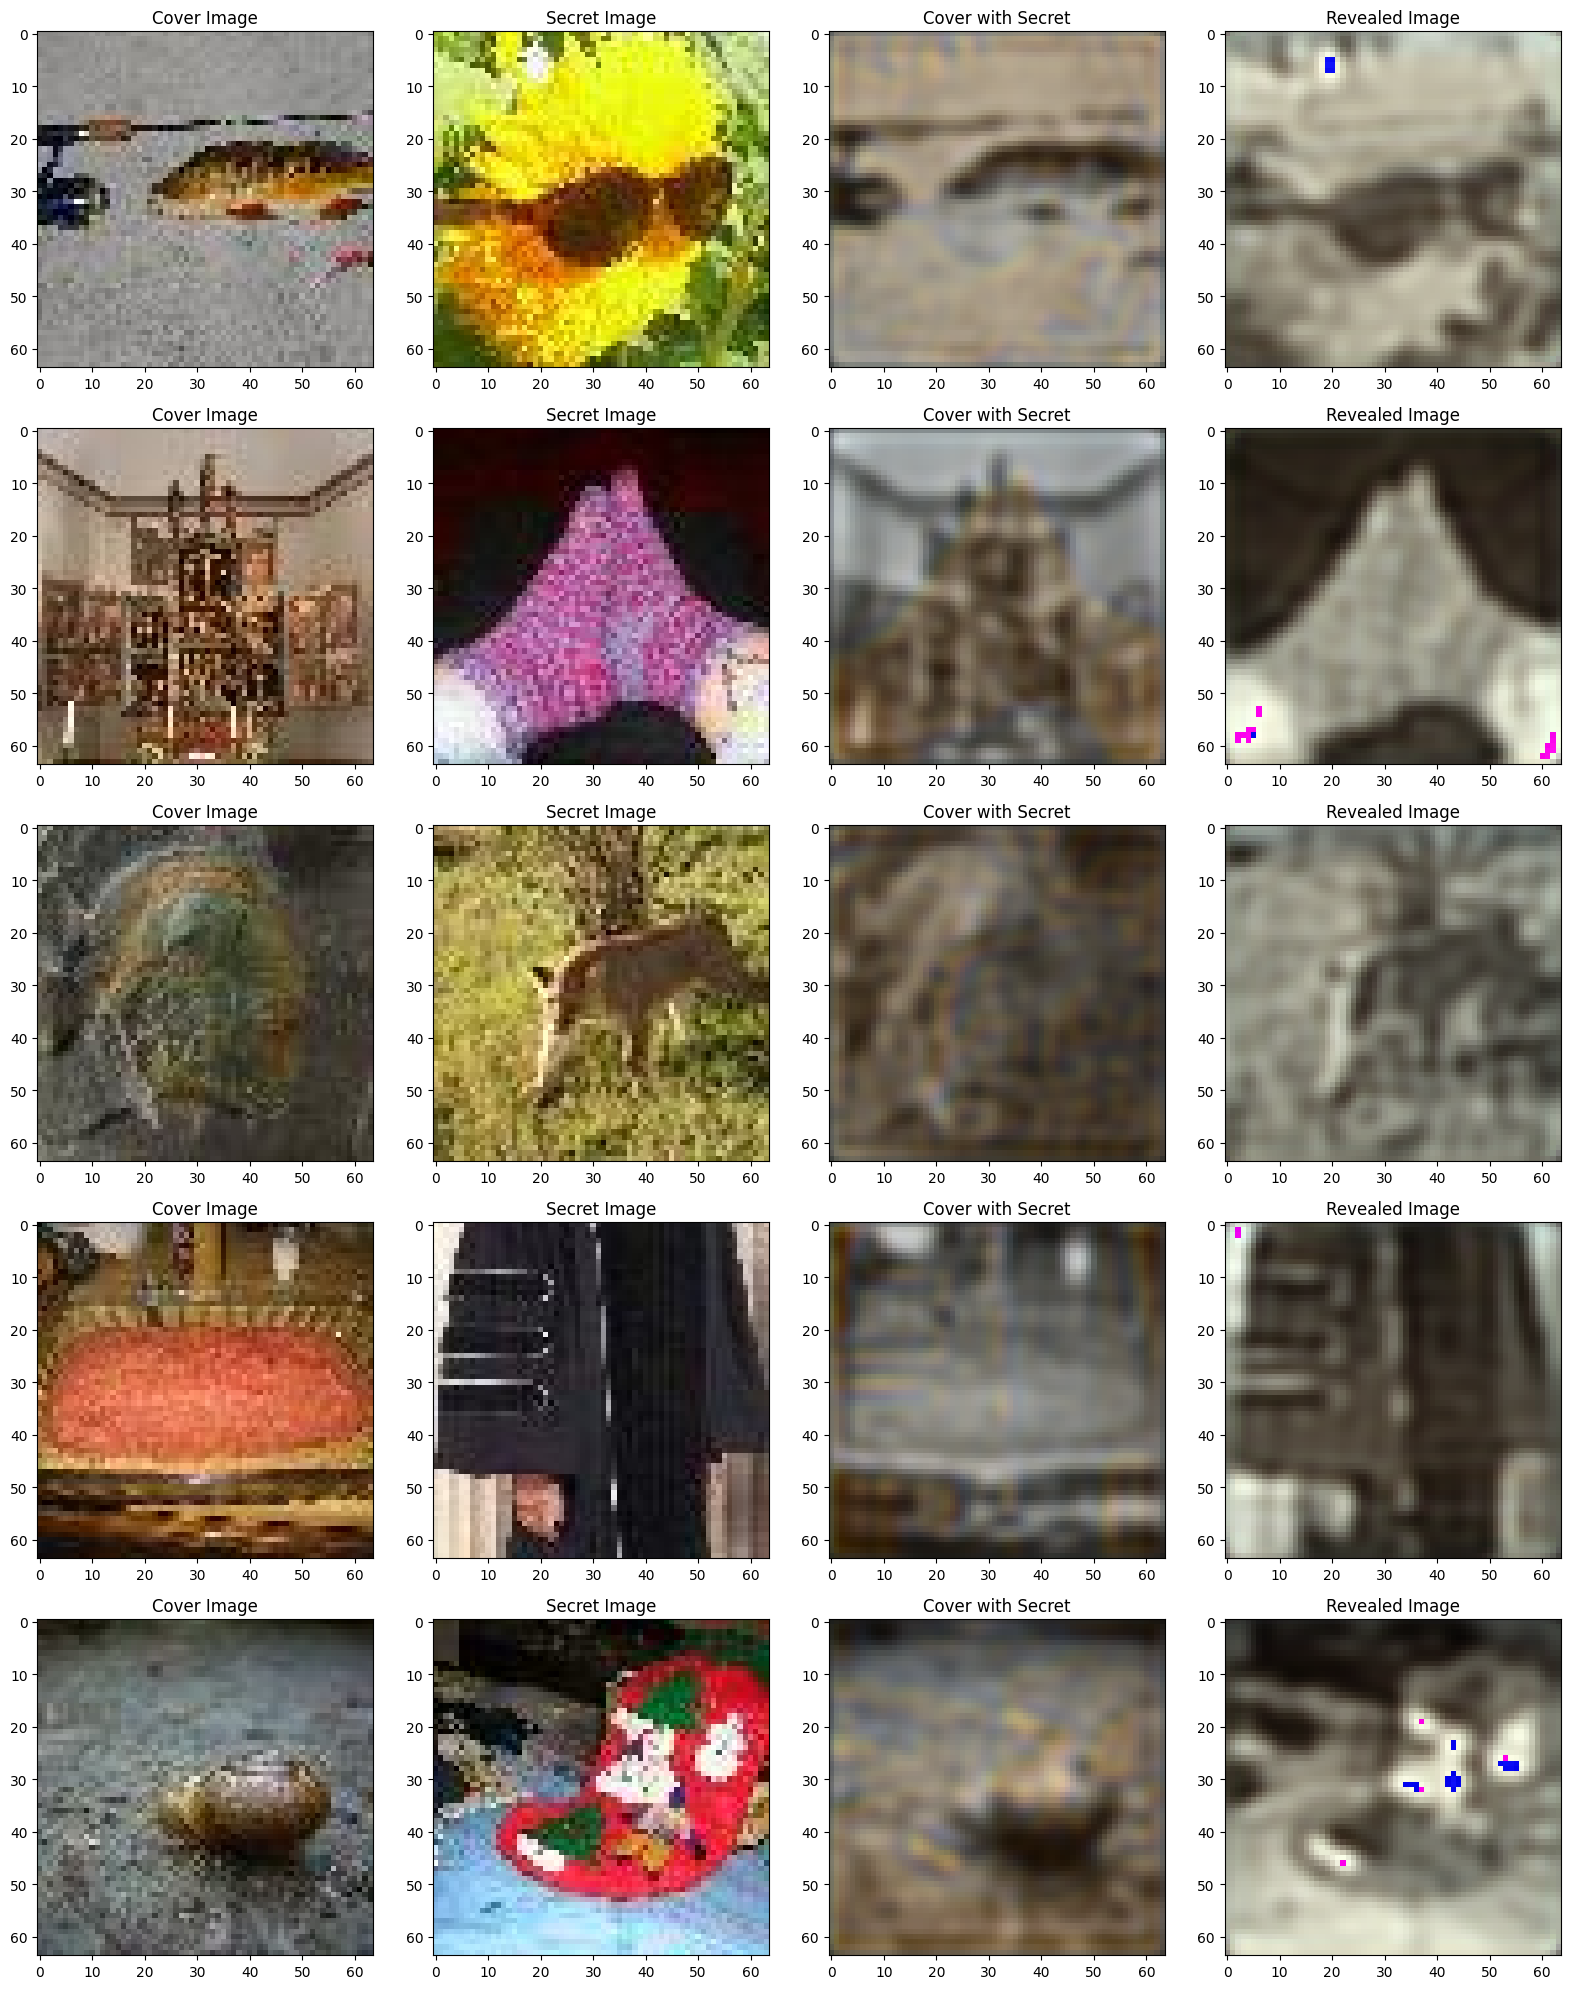

In [49]:
import matplotlib.pyplot as plt

def plot_images(cover_images, secret_images, cover_with_secret_images, revealed_images):
    num_images = len(cover_images)
    fig, axes = plt.subplots(num_images, 4, figsize=(16, num_images * 4))

    for i in range(num_images):
        axes[i, 0].imshow(cover_images[i].astype(np.uint8))
        axes[i, 0].set_title('Cover Image')

        axes[i, 1].imshow(secret_images[i].astype(np.uint8))
        axes[i, 1].set_title('Secret Image')

        axes[i, 2].imshow(cover_with_secret_images[i].astype(np.uint8))
        axes[i, 2].set_title('Cover with Secret')

        axes[i, 3].imshow(revealed_images[i].astype(np.uint8))
        axes[i, 3].set_title('Revealed Image')

    plt.tight_layout()
    plt.show()

num_images = 5  # Define the number of images you want to display

# Ensure num_images does not exceed the length of the dataset
num_images = min(num_images, len(X_test_cover))

cover_images = X_test_cover[:num_images]
secret_images = X_test_secret[:num_images]
cover_with_secret_images = pred[1][:num_images]  # Switched with pred[0]
revealed_images = pred[0][:num_images]  # Switched with pred[1]

plot_images(cover_images, secret_images, cover_with_secret_images, revealed_images)


In [50]:
# pip freeze > requirements.txt